In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
try:
  %tensorflow_version 2.x  #gpu
except Exception:
  pass
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [11]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
om = pd.read_csv('/content/gdrive/My Drive/sentiment/fb_sentiment.csv')

In [13]:
om.head()

,Unnamed: 0,FBPost,Label
0,0,Drug Runners and a U.S. Senator have somethin...,O
1,1,"Heres a single, to add, to Kindle. Just read t...",O
2,2,If you tire of Non-Fiction.. Check out http://...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle...,N


In [15]:
om.columns = map(str.lower, om.columns)

In [14]:
om.shape

(1000, 3)

In [17]:
import re
om['fbpost'] = om['fbpost'].apply(lambda x: x.lower())
om['fbpost'] = om['fbpost'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [18]:
om = om[om.label != "O"]

In [19]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(om['fbpost'].values)
X = tokenizer.texts_to_sequences(om['fbpost'].values)
X = pad_sequences(X)

In [20]:
om.label.value_counts()

P    641
N     79
Name: label, dtype: int64

In [21]:
Y = pd.get_dummies(om['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(482, 203) (482, 2)
(238, 203) (238, 2)


In [23]:
embed_dim = 200
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 203, 200)          400000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 203, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 721,202
Trainable params: 721,202
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
batch_size = 32
hist = model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
16/16 - 21s - loss: 0.4982 - accuracy: 0.8693 - 21s/epoch - 1s/step
Epoch 2/7
16/16 - 18s - loss: 0.3258 - accuracy: 0.8963 - 18s/epoch - 1s/step
Epoch 3/7
16/16 - 18s - loss: 0.2844 - accuracy: 0.8983 - 18s/epoch - 1s/step
Epoch 4/7
16/16 - 18s - loss: 0.2685 - accuracy: 0.8983 - 18s/epoch - 1s/step
Epoch 5/7
16/16 - 18s - loss: 0.1868 - accuracy: 0.9315 - 18s/epoch - 1s/step
Epoch 6/7
16/16 - 18s - loss: 0.1140 - accuracy: 0.9606 - 18s/epoch - 1s/step
Epoch 7/7
16/16 - 18s - loss: 0.0660 - accuracy: 0.9793 - 18s/epoch - 1s/step


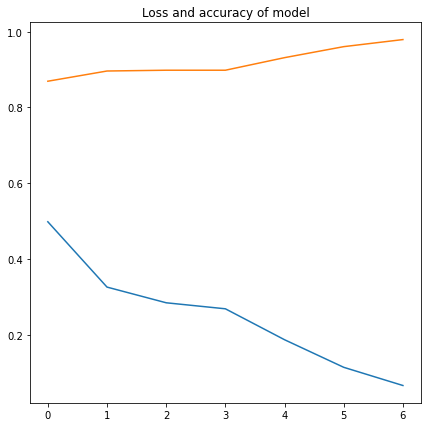

In [25]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(7,7));
plt.plot(history["loss"]);
plt.plot(history["accuracy"]);
plt.title("Loss and accuracy of model");
plt.show();

In [26]:
score,acc = model.evaluate(X_test,Y_test)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

8/8 [==============================] - 1s 137ms/step - loss: 0.4436 - accuracy: 0.8908
score: 0.44
accuracy: 0.89


In [27]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
x_test = X_test[:-validation_size]
y_test = Y_test[:-validation_size]

In [28]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,x_test.shape[1]),verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("positive_acc", pos_correct/pos_cnt*100, "%")
print("negative_acc", neg_correct/neg_cnt*100, "%")

1/1 - 1s - 796ms/epoch - 796ms/step
1/1 - 0s - 150ms/epoch - 150ms/step
1/1 - 0s - 230ms/epoch - 230ms/step
1/1 - 0s - 154ms/epoch - 154ms/step
1/1 - 0s - 136ms/epoch - 136ms/step
1/1 - 0s - 193ms/epoch - 193ms/step
1/1 - 0s - 120ms/epoch - 120ms/step
1/1 - 0s - 112ms/epoch - 112ms/step
1/1 - 0s - 147ms/epoch - 147ms/step
1/1 - 0s - 125ms/epoch - 125ms/step
1/1 - 0s - 155ms/epoch - 155ms/step
1/1 - 0s - 128ms/epoch - 128ms/step
1/1 - 0s - 99ms/epoch - 99ms/step
1/1 - 0s - 108ms/epoch - 108ms/step
1/1 - 0s - 115ms/epoch - 115ms/step
1/1 - 0s - 191ms/epoch - 191ms/step
1/1 - 0s - 156ms/epoch - 156ms/step
1/1 - 0s - 251ms/epoch - 251ms/step
1/1 - 0s - 223ms/epoch - 223ms/step
1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 74ms/epoch - 74ms/step
1/1 - 0s - 77ms/epoch - 77ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 72ms/epoch - 72ms/step
1/1 - 0s - 71ms/epoch - 71ms/step
1/1 - 0s - 88ms/epoch - 88ms/step
1/1 - 0s - 81ms/epoch - 81ms/step
1/1 - 0s - 7

In [29]:
cmnt = ['I have a couple games on my kindle...only problem is my family seems to think I put them on there for them...']
#vectorizing the comment
cmnt = tokenizer.texts_to_sequences(cmnt)
cmnt = pad_sequences(cmnt, maxlen=203, dtype='int32', value=0)
print(cmnt)
sentiment = model.predict(cmnt,batch_size=2,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    1   11
     6 1165  134   20    3    4   88  179   12    3  257  321   